In [33]:
import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.interpolate as scint
import numpy as np
import time
import tqdm as tqdm
from custom_layer import ScaleAngles
import os

# replace the argparse / sys.argv code with a notebook-relative path
nb_dir = os.getcwd()   # notebook working directory (where the .ipynb is opened)
infile = os.path.join(nb_dir, "models", "2026-01-26_model1_s0.9.keras")

# ensure expansion and show status for debugging
infile = os.path.expanduser(infile)
print("Using model file:", infile, "exists:", os.path.exists(infile))


Using model file: /Users/danny/Documents/Courses/Year 4/Code/mldirc/dense/dualfilm/models/2026-01-26_model1_s0.9.keras exists: True


In [34]:
datafrac = 1
indata  = np.load('500K22TO140dualfilm_lowbins.npz', mmap_mode='r')
TIMES   = indata['TIMES']; HISTS = indata['HISTS']; ANGLES = indata['ANGLES']; LABELS = indata['LABELS']
nevents = TIMES.shape[0]

TIMES   = TIMES[int(nevents*(1-datafrac)):]
HISTS   = HISTS[int(nevents*(1-datafrac)):]
ANGLES     = ANGLES[int(nevents*(1-datafrac)):]
LABELS  = LABELS[int(nevents*(1-datafrac)):]


# Expand compressed datatypes to full precision for training
TIMES = TIMES.astype(np.float32)
HISTS = HISTS.astype(np.float32)
ANGLES = ANGLES.astype(np.float32)
LABELS = LABELS.astype(np.int32)

theta = np.arccos(ANGLES.T[6])*180/np.pi

In [35]:
model = keras.models.load_model(infile)

t1 = time.time()
# Make predictions on dataset
predictions = model.predict((TIMES, HISTS, ANGLES), verbose=0)
pred_labels = np.argmax(predictions, axis=1)

t2 = time.time()

print(f'[INFO] Evaluated {nevents} events in {t2-t1} seconds;\n{((t2-t1)/nevents) * 10**6} µs per event')


[INFO] Evaluated 455040 events in 15.664098978042603 seconds;
34.42356491306831 µs per event


MODEL INSPECTION

Output Layer: output
Output dtype: float32
Optimizer: <keras.src.optimizers.adam.Adam object at 0x15e121490>

Predictions dtype: float32
Sample predictions (first 5):
[[0.89814407 0.10185593]
 [0.6643185  0.3356814 ]
 [0.5617409  0.43825912]
 [0.65420693 0.34579304]
 [0.18010892 0.8198911 ]]

Number of unique confidence values: 428358
Confidence range: [0.5000008940696716, 1.0]
Minimum step between unique values: 5.960464477539063e-08
Quantization bits (estimated): 24.0 bits


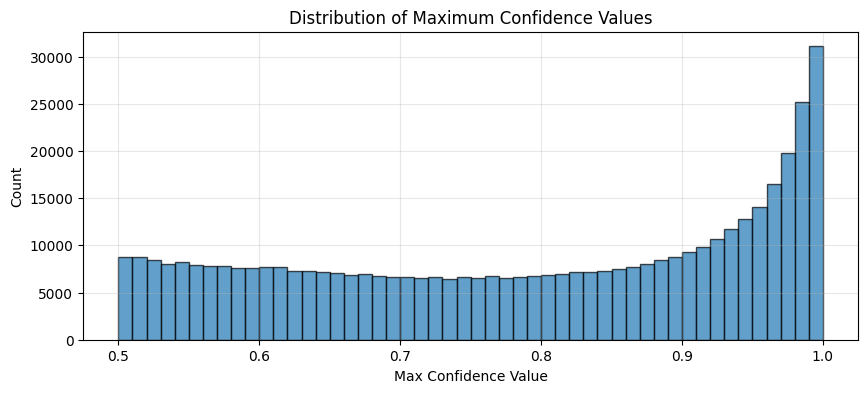


First 20 unique confidence values:
[0.5000009  0.50000113 0.50000226 0.5000027  0.50000274 0.5000028
 0.5000043  0.5000053  0.50000906 0.50000966 0.50001043 0.5000122
 0.50001305 0.5000153  0.50001615 0.5000182  0.5000183  0.5000186
 0.5000194  0.50002116]


In [36]:
# Diagnose model quantization and precision
print("=" * 60)
print("MODEL INSPECTION")
print("=" * 60)

# Check output layer properties
output_layer = model.layers[-1]
print(f"\nOutput Layer: {output_layer.name}")
print(f"Output dtype: {output_layer.dtype}")

# Check for quantization in layer config
if hasattr(model, 'optimizer'):
    print(f"Optimizer: {model.optimizer}")

# Inspect prediction precision
print(f"\nPredictions dtype: {predictions.dtype}")
print(f"Sample predictions (first 5):\n{predictions[:5]}")

# Check unique confidence values and their distribution
max_confidences = np.max(predictions, axis=1)
unique_confidences = np.unique(max_confidences)
print(f"\nNumber of unique confidence values: {len(unique_confidences)}")
print(f"Confidence range: [{float(max_confidences.min())}, {max_confidences.max()}]")

# Compute the quantization step size
if len(unique_confidences) > 1:
    sorted_unique = np.sort(unique_confidences)
    diffs = np.diff(sorted_unique)
    min_step = np.min(diffs[diffs > 0])
    print(f"Minimum step between unique values: {min_step}")
    print(f"Quantization bits (estimated): {-np.log2(min_step)} bits")

# Show histogram of confidence values
plt.figure(figsize=(10, 4))
plt.hist(max_confidences, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Max Confidence Value')
plt.ylabel('Count')
plt.title('Distribution of Maximum Confidence Values')
plt.grid(True, alpha=0.3)
plt.show()

# First 20 unique values
print(f"\nFirst 20 unique confidence values:\n{sorted_unique[:20]}")


In [39]:
confidences = 1 - np.linspace(0.5, 0.997, 100)
accuracies = []


for confidence in tqdm.tqdm(confidences, total=len(confidences), desc='Calculating accuracy vs confidence'):
    correct     = 0
    total       = 0
    for i, pred in enumerate(predictions):
        if pred[np.argmax(pred)] >= 1 - confidence:
            total += 1
            if np.argmax(pred) == LABELS[i]:
                correct += 1
    
    accuracies.append(correct/total if total else 0)


Calculating accuracy vs confidence: 100%|██████████| 100/100 [01:51<00:00,  1.11s/it]


In [40]:
confidence  = 0.008
correct     = 0
total       = 0

print(predictions)

for i, pred in enumerate(predictions):
    if pred[np.argmax(pred)] >= 1 - confidence:
        total += 1
        if np.argmax(pred) == LABELS[i]:
            correct += 1
            
try:
    print(f'Accuracy: {correct} out of {total}... {correct/total:0.5f}\nEvents Kept: {total} out of {predictions.shape[0]}... {total/predictions.shape[0]:0.5f}')
except ZeroDivisionError:
    print('No events kept!')

[[0.89814407 0.10185593]
 [0.6643185  0.3356814 ]
 [0.5617409  0.43825912]
 ...
 [0.9531546  0.04684538]
 [0.9988752  0.00112476]
 [0.9818201  0.01817991]]
Accuracy: 25054 out of 25303... 0.99016
Events Kept: 25303 out of 455040... 0.05561


100 100


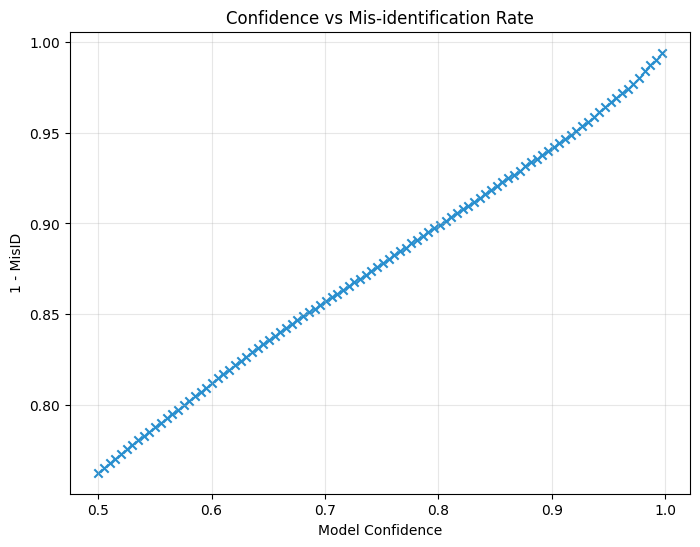

In [ ]:
print(len(accuracies), len(confidences))

mis_id = 1 - np.array(accuracies)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.scatter(1 - confidences, accuracies, marker='x', c="#288ECE")
ax.set_xlabel('Model Confidence')
ax.set_ylabel('1 - MisID')
ax.set_title('Confidence vs Mis-identification Rate')
ax.grid(True, which='both', alpha=0.3)

plt.show()